# Logitic regression

The UiPath ML tutorial used logistic regression too

In [15]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,input,target
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [42]:
train_df.shape

(399, 2)

In [43]:
train_df['input'] = train_df['input'].str.replace(r'<[^<>]*>', '', regex=True)
train_df.head()

,input,target
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [44]:
train_df["target"].unique()

array(['positive', 'negative'], dtype=object)

In [45]:
test_df = pd.read_csv("test.csv")
test_df.head()

,input,target
0,"After a snowstorm, the roads are blocked and t...",negative
1,This movie was a fairly entertaining comedy ab...,positive
2,What can you say about the film White Fire. Am...,positive
3,I am so disappointed. This movie left me feeli...,negative
4,"This movie is all ultra-lightweight fluff, pre...",negative


In [46]:
test_df['input'] = test_df['input'].str.replace(r'<[^<>]*>', '', regex=True)
test_df.head()

,input,target
0,"After a snowstorm, the roads are blocked and t...",negative
1,This movie was a fairly entertaining comedy ab...,positive
2,What can you say about the film White Fire. Am...,positive
3,I am so disappointed. This movie left me feeli...,negative
4,"This movie is all ultra-lightweight fluff, pre...",negative


In [47]:
test_df.shape

(1001, 2)

In [ ]:
test_df["target"].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string
punctuations = string.punctuation
parser = English()
stopwords = list(STOP_WORDS)
def spacy_tokenizer(utterance):
  tokens = parser(utterance)
  return [token.lemma_.lower().strip() for token in tokens if token.text.lower().strip() not in stopwords and token.text not in punctuations]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
#By default, the vectorizer might be created as follows:
#vectorizer = CountVectorizer()
vectorizer.fit(train_df)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7f95752df710>)

In [ ]:
X_train = vectorizer.transform(train_df["input"])
X_test = vectorizer.transform(test_df["input"])
y_train = train_df["target"]
y_test = test_df["target"]

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [ ]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.4745254745254745


In [ ]:
new_reviews = ['the movie is not bad', 'Very good effort, but not five stars', 'Clear and concise']
X_new = vectorizer.transform(new_reviews)
classifier.predict(X_new)

array(['negative', 'negative', 'negative'], dtype=object)

# LSTM

Accuracy is too low for logistic regression

In [48]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [49]:
def cleaning(df, stop_words):

    df['input'] = df['input'].apply(lambda x: 

            ' '.join(x.lower() for x in x.split()))

    # Replacing the special characters

    df['input'] = df['input'].str.replace(r'<[^<>]*>', '', regex=True)

    # Replacing the digits/numbers

    df['input'] = df['input'].str.replace('d', '')

    # Removing stop words

    df['input'] = df['input'].apply(lambda x: 

            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['input'] = df['input'].apply(lambda x: 

            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

train_df = cleaning(train_df, stop_words)
test_df = cleaning(test_df, stop_words)

In [50]:
train_df.head()

,input,target
0,one reviewer mentione watching 1 oz episoe hoo...,positive
1,wonerful little prouction. filming technique u...,positive
2,thought wonerful way spen time hot summer week...,positive
3,basically there's family little boy (jake) thi...,negative
4,"petter mattei's ""love time money"" visually stu...",positive


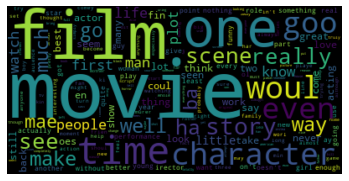

In [51]:
common_words=''
for i in train_df.input:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
X = pd.concat([train_df["input"], test_df["input"]])
y = pd.concat([train_df["target"], test_df["target"]])

lb=LabelEncoder()
y = lb.fit_transform(y)

tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)
X.shape

(1400, 351)

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 351, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 351, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y=pd.get_dummies(y)

X_train = X[:399]
y_train = y[:399]
X_test = X[1001:]
y_test = y[1001:]

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
13/13 [==============================] - 15s 974ms/step - loss: 0.6941 - accuracy: 0.4937
Epoch 2/5
13/13 [==============================] - 13s 969ms/step - loss: 0.6722 - accuracy: 0.6316
Epoch 3/5
13/13 [==============================] - 13s 964ms/step - loss: 0.6230 - accuracy: 0.7444
Epoch 4/5
13/13 [==============================] - 13s 966ms/step - loss: 0.5395 - accuracy: 0.7444
Epoch 5/5
13/13 [==============================] - 13s 966ms/step - loss: 0.4505 - accuracy: 0.8371


In [ ]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 2s 120ms/step - loss: 0.6261 - accuracy: 0.6566


[0.6260745525360107, 0.6566416025161743]

# LSTM Fine-tuning

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 351, 120)          60000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 351, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 176)               209088    
                                                                 
 dense_1 (Dense)             (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0, callbacks=[es])

Epoch 00015: early stopping


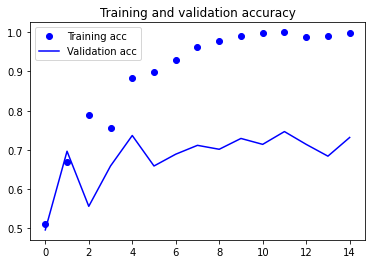

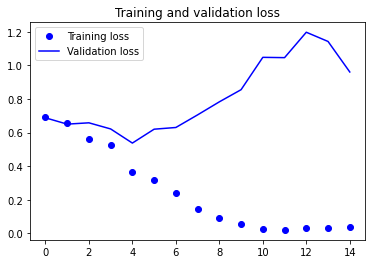

In [ ]:
import matplotlib.pyplot as plt

conv_accuracy2 = history.history['accuracy']
conv_val_acc2 = history.history['val_accuracy']
conv_loss2 = history.history['loss']
conv_val_loss2 = history.history['val_loss']

epochs = range(len(conv_accuracy2))

plt.plot(epochs, conv_accuracy2, 'bo', label='Training acc')
plt.plot(epochs, conv_val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, conv_loss2, 'bo', label='Training loss')
plt.plot(epochs, conv_val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('sa_lstm.h5')

from google.colab import files
files.download('sa_lstm.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history.history['val_accuracy'][4]

0.7368420958518982

In [ ]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 2s 121ms/step - loss: 0.9603 - accuracy: 0.7318


[0.9603340029716492, 0.7318295836448669]

# BERT

Fine tuned LSTM reached accuracy of 0.73, can BERT do better?

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 29.1 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 61 kB 405 kB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model2.fit(X_train, y_train, epochs = 5,
          batch_size=16)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_119', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/5
25/25 [==============================] - 754s 30s/step - loss: 7.4881 - accuracy: 0.5188
Epoch 2/5
25/25 [==============================] - 738s 30s/step - loss: 7.6349 - accuracy: 0.5263
Epoch 3/5
25/25 [==============================] - 737s 29s/step - loss: 7.6349 - accuracy: 0.5263
Epoch 4/5
25/25 [==============================] - 741s 30s/step - loss: 7.6349 - accuracy: 0.5263
Epoch 5/5
25/25 [==============================] - 746s 30s/step - loss: 7.6349 - accuracy: 0.5263


In [ ]:
model2.evaluate(X_test,y_test)

13/13 [==============================] - 223s 17s/step - loss: 8.4428 - accuracy: 0.4762


[8.442811965942383, 0.4761904776096344]

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
  analysis=TextBlob(text)
  sentiment_score = analysis.sentiment.polarity
  if sentiment_score < 0:
    return "negative"
  else:
    return "positive"

print(get_sentiment("The movie is not bad"))
print(get_sentiment("The movie is bad"))

positive
negative


In [ ]:
train_df["sentiment"] = train_df["input"].apply(get_sentiment)

train_df.head()

,input,target,sentiment
0,one reviewer mentione watching 1 oz episoe hoo...,positive,positive
1,wonerful little prouction. filming technique u...,positive,positive
2,thought wonerful way spen time hot summer week...,positive,positive
3,basically there's family little boy (jake) thi...,negative,negative
4,"petter mattei's ""love time money"" visually stu...",positive,positive


In [ ]:
train_df.shape

(399, 3)

In [ ]:
train_df[train_df["target"]==train_df["sentiment"]]

,input,target,sentiment
0,one reviewer mentione watching 1 oz episoe hoo...,positive,positive
1,wonerful little prouction. filming technique u...,positive,positive
2,thought wonerful way spen time hot summer week...,positive,positive
3,basically there's family little boy (jake) thi...,negative,negative
4,"petter mattei's ""love time money"" visually stu...",positive,positive
...,...,...,...
392,course woul give film 10 10 uncle main screenp...,positive,positive
394,helena bonham carter center movie. play role a...,positive,positive
395,"commente first ebute gave ""thumbs mile"" review...",negative,negative
397,"""hey babu riba"" film young woman, mariana (nic...",positive,positive


In [ ]:
test_df["sentiment"] = test_df["input"].apply(get_sentiment)

test_df.head()

,input,target,sentiment
0,"snowstorm, roas blocke highway patrolman jason...",negative,negative
1,movie fairly entertaining comey murphy's law a...,positive,positive
2,say film white fire. amazing? fantastic? istur...,positive,positive
3,isappointe. movie left feeling jippe time ment...,negative,positive
4,"movie ultra-lightweight fluff, preictable begi...",negative,positive


In [ ]:
test_df.shape

(1001, 3)

In [ ]:
test_df[test_df["target"]==test_df["sentiment"]]

,input,target,sentiment
0,"snowstorm, roas blocke highway patrolman jason...",negative,negative
1,movie fairly entertaining comey murphy's law a...,positive,positive
2,say film white fire. amazing? fantastic? istur...,positive,positive
5,intereste learning sort thing happening moern ...,positive,positive
8,thing able look back year 2006 say rocke. rock...,positive,positive
...,...,...,...
996,"first saw movie vieo store an, bam margera fan...",positive,positive
997,"love it, really gruesome isgusting. thought te...",positive,positive
998,citizen kane....the gofather part ii....'urvil...,positive,positive
999,"ok. whole, three part ocumentary bring interes...",positive,positive


# Reusing trained BERT

In [1]:
import pandas as pd

df = pd.read_excel ('Movie_Reviews.xlsx')
print(df)

                                        Movie Reviews  ...  Confidence
0   I am a huge fan of Harald Zwart, and I just kn...  ...         NaN
1   I can't believe that those praising this movie...  ...         NaN
2   This film really used its locations well with ...  ...         NaN
3   Strangely enough this movie never made it to t...  ...         NaN
4   This movie is awful, I can't even be bothered ...  ...         NaN
5   Based on the best-selling novel "The Dismissal...  ...         NaN
6   I found it very very difficulty to watch this ...  ...         NaN
7   This movie is a real low budget production, ye...  ...         NaN
8   Why do movie makers always go against the auth...  ...         NaN
9   What a fun filled, sexy movie! They certainly ...  ...         NaN
10  Jackass Number Two is easily the most hilariou...  ...         NaN
11  Turn your backs away or you're gonna get in bi...  ...         NaN
12  I remember the events of this movie, the ill f...  ...         NaN
13  I 

In [53]:
# loading model
import keras
import keras.preprocessing.text
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# It can be used to reconstruct the model identically.
model = keras.models.load_model("sa_lstm.h5")

X_pred = df["Movie Reviews"]
# tokenizer = Tokenizer(num_words=500, split=' ') 
# tokenizer.fit_on_texts(train_df)
X_pred = tokenizer.texts_to_sequences(X_pred)
X_pred = pad_sequences(X_pred)
X_pred.shape
# prediction = model.predict(X_test)
# print(prediction)

(15, 420)

In [54]:
prediction = model.predict(X_test)
print(prediction)

[[0.52201927 0.47798082]
 [0.4076208  0.59237915]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.47798082]
 [0.52201927 0.4779808 ]
 [0.52201927 0.4779808 ]
 [0.52201927 0.4779808 ]]
